In [1]:
!pip -q install pyshp
!pip -q install influxdb
!pip -q install shapely
!pip -q install ipyleaflet
!pip -q install plotly

In [2]:
import shapefile
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import time
import numpy as np
import tarfile
from six.moves import urllib
import json
import os
from influxdb import DataFrameClient
from dotenv import load_dotenv
from shapely.geometry import Point, Polygon
from ipyleaflet import Map, GeoJSON, basemaps, Polyline, Heatmap
import requests
from datetime import datetime, timedelta
from scipy.stats import gaussian_kde
from scipy import stats
%matplotlib inline

load_dotenv()

In [3]:
def rm_outside_polygon(res_pd_frame,polygon):
    res_pd_frame_1 = res_pd_frame[['lon','lat','sensor_id']]
    res_pd_frame_2 = res_pd_frame_1.reset_index()
    res_pd_frame_3 = res_pd_frame_2.drop(columns=['index'])
    res_pd_frame4 = res_pd_frame_3.drop_duplicates()
    res_pd_frame4["polygon1"] = res_pd_frame4.apply(lambda row: Polygon(poly).intersects(Point(row["lon"], row["lat"])), axis = 1)
    res_pd_frame5 = res_pd_frame4.drop(res_pd_frame4[res_pd_frame4["polygon1"]].index)
    res_pd_frame = res_pd_frame[~res_pd_frame.sensor_id.isin(res_pd_frame5.sensor_id)]     
    return res_pd_frame

In [4]:
#sf = shapefile.Reader("landkreise-in-germany.shp") # This is Göttingen
#s = sf.shape(0)

sf = shapefile.Reader("bundesland.shp") # Complete germany, 16 shapes for each bundesland
s = sf.shape(3) # Baden-Württemberg
poly = Polygon(s.points)  # Convert to polygon to use shapely function point.within(polygon)

geo_json = GeoJSON(data=s.__geo_interface__, style = {'color': 'red', 'opacity':1, 'weight':1.9, 'dashArray':'9', 'fillOpacity':0.1})

In [5]:
def main(host=os.getenv("HOST"), port=os.getenv("PORT"), rectangle=[0,0,0,0],time_range=["",""],limit=100):
    """Instantiate the connection to the InfluxDB client."""
    user = os.getenv("USER")
    password = os.getenv("PASSWORD")
    dbname = os.getenv("DB")
    protocol = 'line'

    client = DataFrameClient(host, port, user, password, dbname, ssl=True, verify_ssl=True)

    bind_params = {
        "start_time_epoch": time_range[0],
        "end_time_epoch": time_range[1]
    }
    measurement = "P1, humidity, lat, lon, sensor_id"
    
    #measurement = "P1, temperature, lat, lon, sensor_id"
    
    query = f"select {measurement} from sensor where \
                     time > $start_time_epoch AND \
                     time < $end_time_epoch AND \
                     lon > {rectangle[0]} AND \
                     lon < {rectangle[2]} AND \
                     lat > {rectangle[1]} AND \
                     lat < {rectangle[3]} \
                     limit {limit}"
                
    res=client.query(query, bind_params=bind_params)
    return res

In [6]:
m = Map(center=(48.7,9.8,0 ), zoom=8, basemap=basemaps.Hydda.Full)
m.add_layer(geo_json)

## Change the 'start_date' & 'date_to_end_query' for changing the time duration of query

In [7]:
start_date = datetime(2017, 1, 2)
end_date = start_date + timedelta(hours=1)

date_to_start_query = start_date
date_to_end_query = datetime(2017, 1, 3)

appended_res_pd_frame_plot_timeindex = []
appended_drop_P1 = []
appended_mean_P1_humi = []

j = 0
number = 5
while number >= 5:
    start_time = time.time()
    
    time_range=[start_date.strftime("%Y-%m-%dT%H:%M:%SZ"),end_date.strftime("%Y-%m-%dT%H:%M:%SZ")]
    print(time_range)
    
    res_P1_humi=main(rectangle=s.bbox,time_range=time_range,limit=10000)
    
    if not res_P1_humi:
        print('Data empty in %s' %time_range)
        start_date=end_date
        end_date=start_date + timedelta(hours=1)
        
    if res_P1_humi:    
        res_pd_frame_P1_humi=rm_outside_polygon(res_P1_humi['sensor'],poly)
    
        res_pd_frame_P1_humi = res_pd_frame_P1_humi.drop([ 'lat', 'lon', 'sensor_id'], axis = 1)
        res_pd_frame_mean_P1_humi = res_pd_frame_P1_humi.mean(axis = 0, skipna = True)
        res_pd_frame_mean_P1_humi = res_pd_frame_mean_P1_humi.to_frame()
        res_pd_frame_mean_P1_humi = res_pd_frame_mean_P1_humi.swapaxes("index", "columns") 
        res_pd_frame_mean_P1_humi = res_pd_frame_mean_P1_humi.rename(index={0: start_date})
        
        appended_mean_P1_humi.append(res_pd_frame_mean_P1_humi)  


        start_date=end_date
        end_date=start_date + timedelta(hours=1)
        print("--- %s seconds ---" % (time.time() - start_time))
    
    if start_date == date_to_end_query: 
        break

appended_mean_P1_humi = pd.concat(appended_mean_P1_humi)
appended_mean_P1_humi


['2017-01-02T00:00:00Z', '2017-01-02T01:00:00Z']


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



--- 1.5252299308776855 seconds ---
['2017-01-02T01:00:00Z', '2017-01-02T02:00:00Z']
--- 1.3397889137268066 seconds ---
['2017-01-02T02:00:00Z', '2017-01-02T03:00:00Z']
--- 1.4357352256774902 seconds ---
['2017-01-02T03:00:00Z', '2017-01-02T04:00:00Z']
--- 1.4288403987884521 seconds ---
['2017-01-02T04:00:00Z', '2017-01-02T05:00:00Z']
--- 1.3700966835021973 seconds ---
['2017-01-02T05:00:00Z', '2017-01-02T06:00:00Z']
--- 1.5342066287994385 seconds ---
['2017-01-02T06:00:00Z', '2017-01-02T07:00:00Z']
--- 1.4180326461791992 seconds ---
['2017-01-02T07:00:00Z', '2017-01-02T08:00:00Z']
--- 1.5106697082519531 seconds ---
['2017-01-02T08:00:00Z', '2017-01-02T09:00:00Z']
--- 1.4545576572418213 seconds ---
['2017-01-02T09:00:00Z', '2017-01-02T10:00:00Z']
--- 1.4626784324645996 seconds ---
['2017-01-02T10:00:00Z', '2017-01-02T11:00:00Z']
--- 1.4139692783355713 seconds ---
['2017-01-02T11:00:00Z', '2017-01-02T12:00:00Z']
--- 1.5757997035980225 seconds ---
['2017-01-02T12:00:00Z', '2017-01-02T13:0

,P1,humidity
2017-01-02 00:00:00,1390.907851,78.537593
2017-01-02 01:00:00,485.289026,79.841981
2017-01-02 02:00:00,874.504325,79.827335
2017-01-02 03:00:00,449.250815,80.016781
2017-01-02 04:00:00,874.859992,79.923909
2017-01-02 05:00:00,373.986246,78.868970
2017-01-02 06:00:00,913.594447,79.076316
2017-01-02 07:00:00,600.529593,77.913088
2017-01-02 08:00:00,892.975568,76.660367
2017-01-02 09:00:00,371.023235,75.722951


In [8]:
pd.set_option('display.max_rows', 10)
appended_mean_P1_humi

,P1,humidity
2017-01-02 00:00:00,1390.907851,78.537593
2017-01-02 01:00:00,485.289026,79.841981
2017-01-02 02:00:00,874.504325,79.827335
2017-01-02 03:00:00,449.250815,80.016781
2017-01-02 04:00:00,874.859992,79.923909
...,...,...
2017-01-02 19:00:00,774.643935,80.585891
2017-01-02 20:00:00,916.718162,80.800388
2017-01-02 21:00:00,1005.864328,80.566069
2017-01-02 22:00:00,1034.373806,80.580506


In [9]:
df = res_pd_frame_P1_humi.loc[res_pd_frame_P1_humi['P1'] > 1500]
df

,P1,humidity
2017-01-02 23:01:57.178315008+00:00,5842.63,NaN
2017-01-02 23:03:31.819357952+00:00,1883.26,NaN
2017-01-02 23:04:54.643458048+00:00,2075.65,NaN
2017-01-02 23:05:36.264438016+00:00,2733.70,NaN
2017-01-02 23:07:40.218962944+00:00,2336.54,NaN
...,...,...
2017-01-02 23:53:13.900743936+00:00,2133.57,NaN
2017-01-02 23:55:17.999170048+00:00,2138.47,NaN
2017-01-02 23:55:59.510446080+00:00,1822.23,NaN
2017-01-02 23:58:08.938479104+00:00,2347.45,NaN


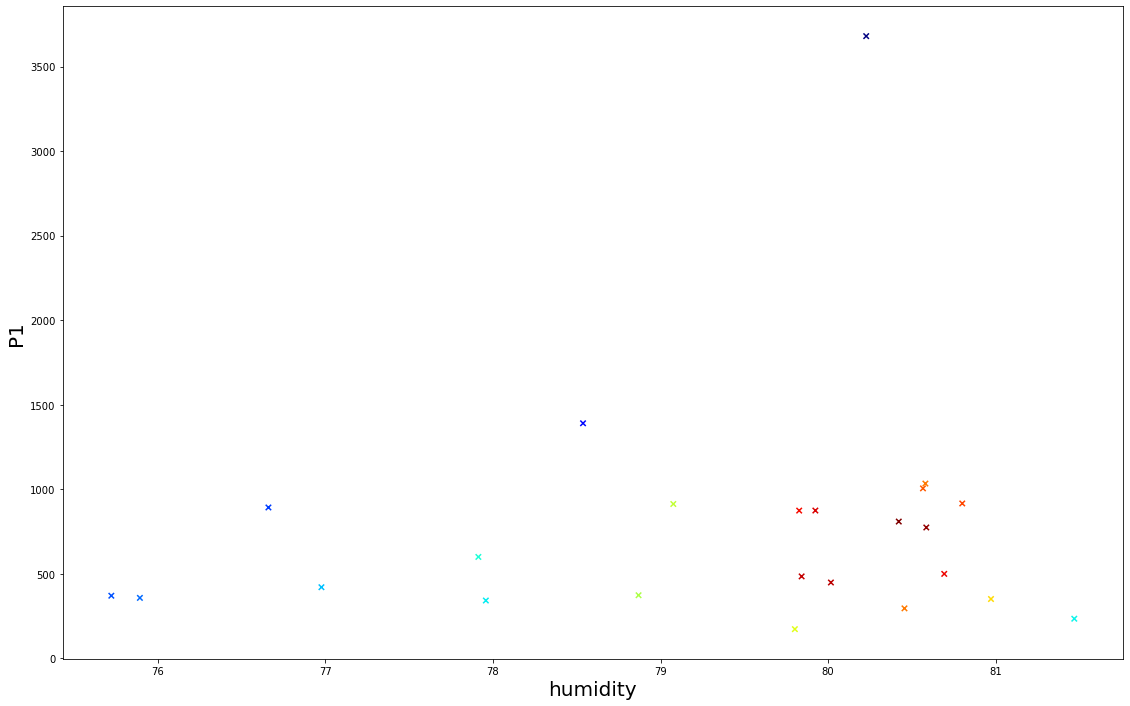

In [12]:
plt.rcParams["figure.figsize"] = (19, 12)
x = appended_mean_P1_humi.humidity
y = appended_mean_P1_humi.P1

# Calculate the point density 
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=30, edgecolor='',marker = "x", cmap=plt.cm.jet)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

plt.xlabel('humidity', fontsize=20)
plt.ylabel('P1', fontsize=20)
plt.show()

# Z-score (Standard Deviation)

In [13]:
P1_humi_drop_outliers = appended_mean_P1_humi[(np.abs(stats.zscore(appended_mean_P1_humi)) < 3).all(axis=1)]
P1_humi_drop_outliers

,P1,humidity
2017-01-02 00:00:00,1390.907851,78.537593
2017-01-02 01:00:00,485.289026,79.841981
2017-01-02 02:00:00,874.504325,79.827335
2017-01-02 03:00:00,449.250815,80.016781
2017-01-02 04:00:00,874.859992,79.923909
...,...,...
2017-01-02 19:00:00,774.643935,80.585891
2017-01-02 20:00:00,916.718162,80.800388
2017-01-02 21:00:00,1005.864328,80.566069
2017-01-02 22:00:00,1034.373806,80.580506


In [14]:
z = np.abs(stats.zscore(appended_mean_P1_humi))
print(z)

[[0.93147502 0.48550772]
 [0.39573087 0.31919465]
 [0.17467339 0.31015898]
 [0.44854572 0.42703226]
 [0.17519463 0.36973733]
 [0.55884773 0.28107479]
 [0.2319609  0.15315916]
 [0.22684308 0.87077715]
 [0.20174344 1.64360507]
 [0.56319009 2.22191507]
 [0.58191768 2.1167533 ]
 [0.48936859 1.44845308]
 [0.6046711  0.84323219]
 [0.85287499 0.29433008]
 [4.28692958 0.55686179]
 [0.76249476 1.32285148]
 [0.59169318 1.01626125]
 [0.37376077 0.84416556]
 [0.67276821 0.69777716]
 [0.02832562 0.77812694]
 [0.23653878 0.9104545 ]
 [0.3671846  0.76589854]
 [0.40896591 0.77480476]
 [0.07971489 0.67682226]]


In [15]:
z.shape

(24, 2)

In [16]:
threshold = 3
print(np.where(z > 3))

(array([14]), array([0]))


In [17]:
print(z[1][0])

0.39573086630737314


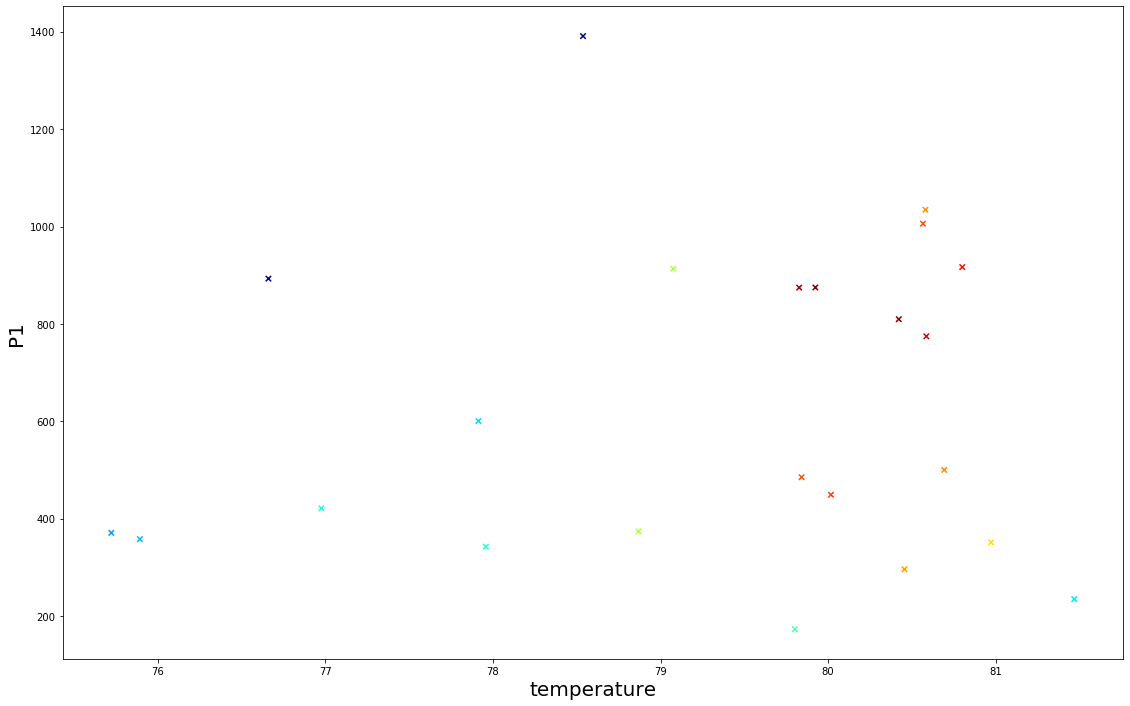

In [18]:
#plotting with z-score
plt.rcParams["figure.figsize"] = (19, 12)
x = P1_humi_drop_outliers.humidity
y = P1_humi_drop_outliers.P1

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=30, edgecolor='',marker = "x", cmap=plt.cm.jet)
plt.xlabel('temperature', fontsize=20)
plt.ylabel('P1', fontsize=20)
plt.show()

# IQR score, IQR = Q3 − Q1

In [19]:
Q1 = appended_mean_P1_humi.quantile(0.25)
Q3 = appended_mean_P1_humi.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

P1          530.301745
humidity      2.177049
dtype: float64


In [20]:
df = (appended_mean_P1_humi < (Q1 - 1.5 * IQR)) |(appended_mean_P1_humi > (Q3 + 1.5 * IQR))
df

,P1,humidity
2017-01-02 00:00:00,False,False
2017-01-02 01:00:00,False,False
2017-01-02 02:00:00,False,False
2017-01-02 03:00:00,False,False
2017-01-02 04:00:00,False,False
...,...,...
2017-01-02 19:00:00,False,False
2017-01-02 20:00:00,False,False
2017-01-02 21:00:00,False,False
2017-01-02 22:00:00,False,False


In [25]:
P1_humidity_rm_out = df[-df.P1]
P1_humidity_rm_out = P1_humidity_rm_out[-P1_humidity_rm_out.humidity]
P1_humidity_rm_out

,P1,humidity
2017-01-02 00:00:00,False,False
2017-01-02 01:00:00,False,False
2017-01-02 02:00:00,False,False
2017-01-02 03:00:00,False,False
2017-01-02 04:00:00,False,False
...,...,...
2017-01-02 19:00:00,False,False
2017-01-02 20:00:00,False,False
2017-01-02 21:00:00,False,False
2017-01-02 22:00:00,False,False


In [26]:
appended_mean_P1_humi_valid = appended_mean_P1_humi[~((appended_mean_P1_humi < (Q1 - 1.5 * IQR)) |(appended_mean_P1_humi > (Q3 + 1.5 * IQR))).any(axis=1)]
appended_mean_P1_humi_valid

,P1,humidity
2017-01-02 00:00:00,1390.907851,78.537593
2017-01-02 01:00:00,485.289026,79.841981
2017-01-02 02:00:00,874.504325,79.827335
2017-01-02 03:00:00,449.250815,80.016781
2017-01-02 04:00:00,874.859992,79.923909
...,...,...
2017-01-02 19:00:00,774.643935,80.585891
2017-01-02 20:00:00,916.718162,80.800388
2017-01-02 21:00:00,1005.864328,80.566069
2017-01-02 22:00:00,1034.373806,80.580506


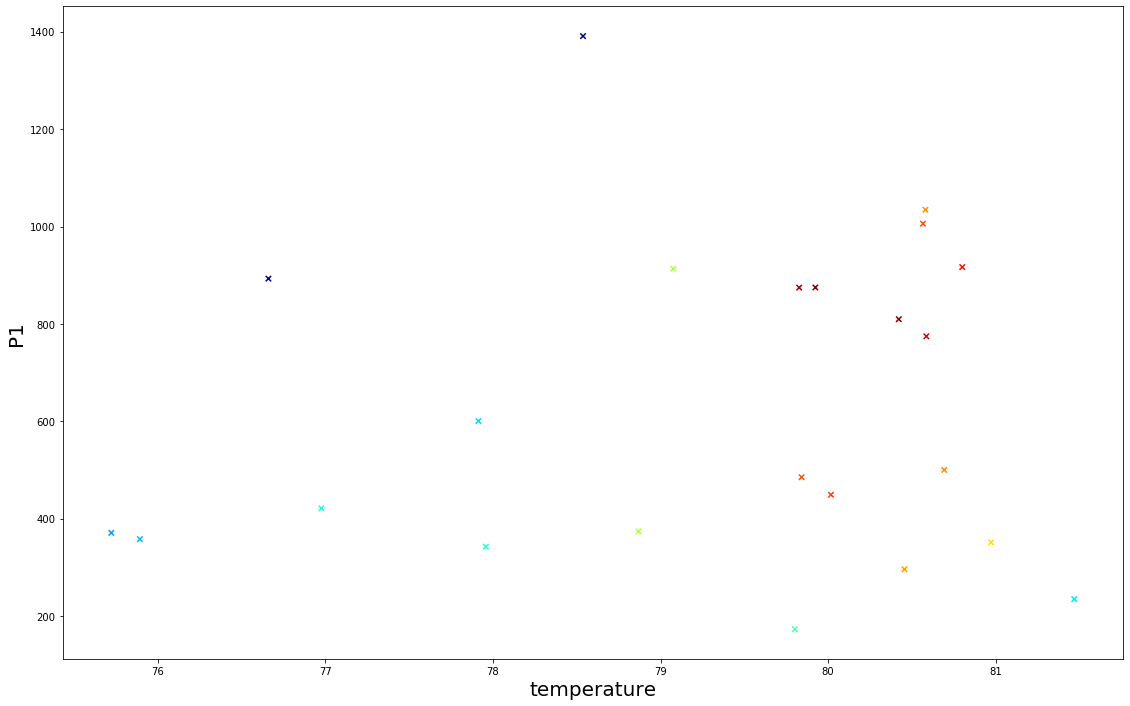

In [27]:
# plotting with IQR-score
plt.rcParams["figure.figsize"] = (19, 12)
x = appended_mean_P1_humi_valid.humidity
y = appended_mean_P1_humi_valid.P1

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=30, edgecolor='',marker = "x", cmap=plt.cm.jet)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

plt.xlabel('temperature', fontsize=20)
plt.ylabel('P1', fontsize=20)
plt.show()

# Isolation forest

In [29]:
from sklearn.ensemble import IsolationForest

In [30]:
iso_forest = IsolationForest(n_estimators=300, contamination=0.10)
iso_forest = iso_forest.fit(appended_mean_P1_humi)

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



In [31]:
isof_outliers = iso_forest.predict(appended_mean_P1_humi)

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.



In [32]:
isoF_non_outliers_values = appended_mean_P1_humi[iso_forest.predict(appended_mean_P1_humi) == 1]

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.



In [33]:
isoF_outliers_values = appended_mean_P1_humi[iso_forest.predict(appended_mean_P1_humi) == -1]

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.



In [34]:
isoF_outliers_values

,P1,humidity
2017-01-02 00:00:00,1390.907851,78.537593
2017-01-02 08:00:00,892.975568,76.660367
2017-01-02 14:00:00,3680.501985,80.227229


In [35]:
isoF_non_outliers_values

,P1,humidity
2017-01-02 01:00:00,485.289026,79.841981
2017-01-02 02:00:00,874.504325,79.827335
2017-01-02 03:00:00,449.250815,80.016781
2017-01-02 04:00:00,874.859992,79.923909
2017-01-02 05:00:00,373.986246,78.868970
...,...,...
2017-01-02 19:00:00,774.643935,80.585891
2017-01-02 20:00:00,916.718162,80.800388
2017-01-02 21:00:00,1005.864328,80.566069
2017-01-02 22:00:00,1034.373806,80.580506


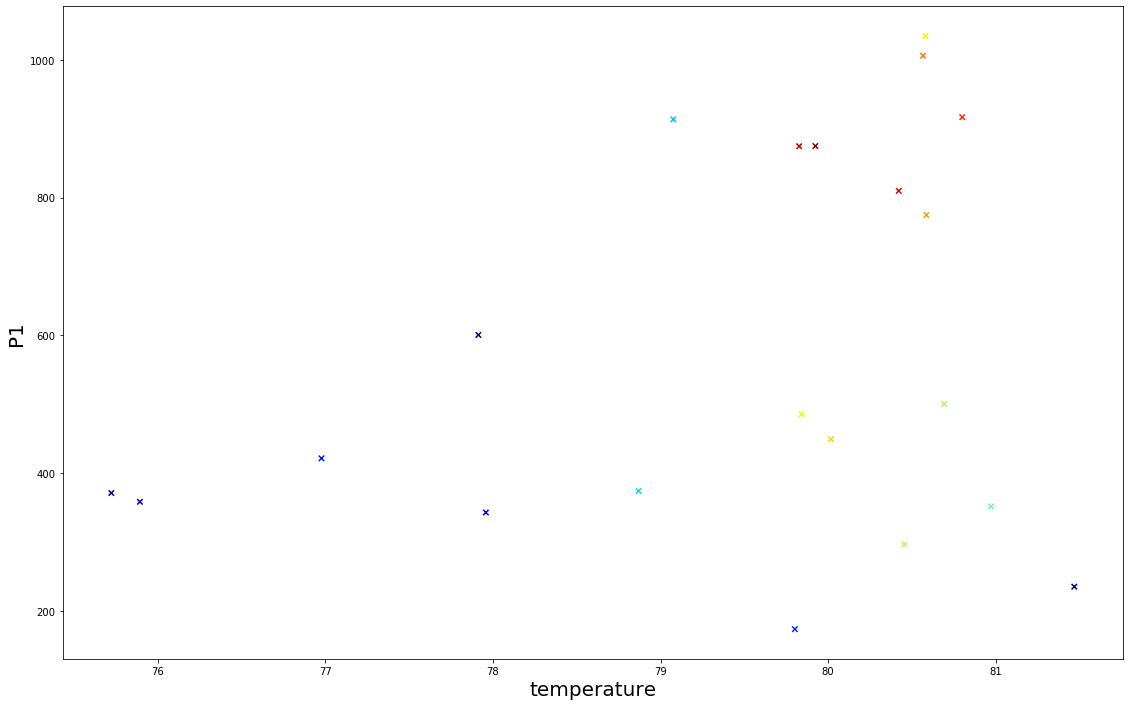

In [36]:
# plotting with isolation forest
plt.rcParams["figure.figsize"] = (19, 12)
x = isoF_non_outliers_values.humidity
y = isoF_non_outliers_values.P1

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=30, edgecolor='',marker = "x", cmap=plt.cm.jet)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

plt.xlabel('temperature', fontsize=20)
plt.ylabel('P1', fontsize=20)
plt.show()

In [37]:
isoF_non_outliers_values['P1'].corr(isoF_non_outliers_values['humidity'])

0.2988029543679465

In [39]:
corrMatrix = isoF_non_outliers_values.corr()
print (corrMatrix)

                P1  humidity
P1        1.000000  0.298803
humidity  0.298803  1.000000
